## Social Media Popularity Prediction

@sitaomin

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as spstats
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

### Data Exploration

In [2]:
data = pd.read_csv('./Data/reddit.csv')
data.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,1/25/2008,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,1/25/2008,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,1/25/2008,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,1/25/2008,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,1/25/2008,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


#### Validation
Drop 'category' 'down_votes' and 'time_created' since they are all equal for all samples

In [3]:
for col in data.columns:
    print("#unique: ({}) - {} ".format(col, data[col].nunique()))
    
data = data.drop(['down_votes', 'category'], axis = 1)

#unique: (time_created) - 508329 
#unique: (date_created) - 3223 
#unique: (up_votes) - 5782 
#unique: (down_votes) - 1 
#unique: (title) - 500713 
#unique: (over_18) - 2 
#unique: (author) - 85807 
#unique: (category) - 1 


#### Exploring time pattern of up_votes and #posts

<AxesSubplot:xlabel='date_created'>

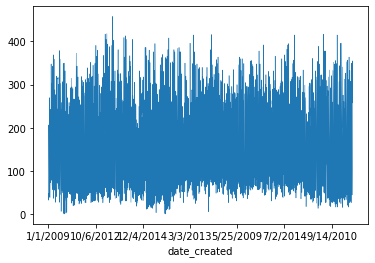

In [4]:
data.groupby('date_created').size().plot(linewidth=0.5)

<AxesSubplot:xlabel='date_created'>

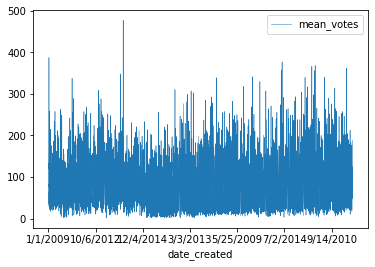

In [5]:
data.groupby('date_created').agg(mean_votes=pd.NamedAgg(column="up_votes", aggfunc="mean")).plot(linewidth=0.5)

Up votes and #post increasing with as time goes off

#### Top posted authors and top voted authors

In [30]:
# top author
author_group = data.groupby('author')
author_post_counts = author_group.size()
#author_post_counts.describe()
top_author = author_post_counts.sort_values(ascending = False).iloc[0:10].index

# top voted author
avg = author_group.agg(mean_votes_per_post=pd.NamedAgg(column="up_votes", aggfunc=lambda x: x.mean()))
top_voted_author = avg.sort_values(by = 'mean_votes_per_post', ascending = False).iloc[0:100].index

### Prection Task： Predict numebr of upvotes of reddit post

- predict number of upvotes of reddit post based on structure features (time, author) and unstructure features (title)

#### Transformation of up votes
- log transformation of upvotes
- box-cox transformation of upvotes

<AxesSubplot:>

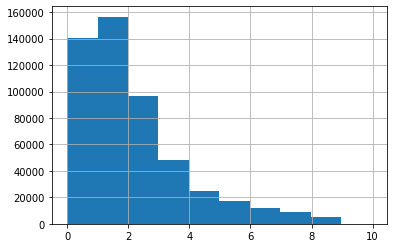

In [7]:
data['log_up_votes'] = np.log(data['up_votes'] + 1)
data['log_up_votes'].hist()

<AxesSubplot:>

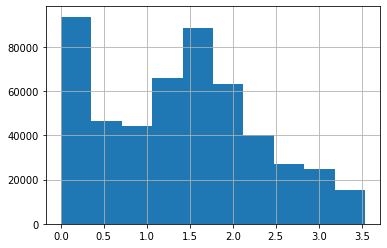

In [8]:
data['bc_up_votes'], opt_lambda = spstats.boxcox(data['up_votes']+1)
data['bc_up_votes'].hist()

### Structure Feature Engineering

In this section, we do feature engineering for structure features including post date, time, author, over_18

#### Time/Date

For date and time, we extract year, month, quarter, day of week, day of months, week of year, day of year  

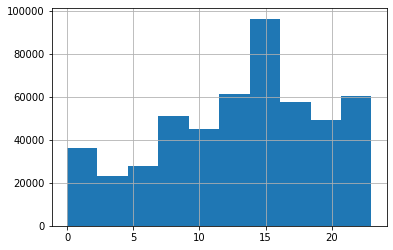

In [9]:
# hour
time_created = data['time_created'].apply(lambda x: datetime.utcfromtimestamp(x))
data['hour'] = time_created.dt.hour
data = data.drop('time_created', axis = 1)
data['hour'].hist()

# date
data['date_created'] = pd.to_datetime(data['date_created'])

In [10]:
# year, month, day, dayofweek, dayofyear, week, quarter
data['year'] = data['date_created'].dt.year
data['month'] = data['date_created'].dt.month
data['day'] = data['date_created'].dt.day
data['weekday'] = data['date_created'].dt.weekday
data['dayofyear'] = data['date_created'].dt.dayofyear
data['week'] = data['date_created'].dt.isocalendar().week
data['quarter'] = data['date_created'].dt.quarter

In [11]:
# encoding - year label, quarter one-hot
labelencoder = LabelEncoder()
data['year_code'] = labelencoder.fit_transform(data['year'])
data = pd.get_dummies(data, columns=["quarter"], prefix=["quarter_"] )

#### Encode Author and over_18

In [12]:
data['over_18'] = labelencoder.fit_transform(data['over_18'])
data['author_code'] = labelencoder.fit_transform(data['author'])

#### Other Features

In [13]:
data['title_len'] = data.apply(lambda row: len(row['title'].split()),axis = 1);
data['title_num_char'] = data.apply(lambda row: len(list(row['title'])), axis = 1)

#### Structure Feature Summary

- numerical
    - Time: year, month, day, week, dayOfWeek, dayOfYear
    - author id
- categorical
    - over_18
    - quarter

### Title Feature Encoding  

#### Preprocessing the title text
- remove stopwords
- remove puctuations and special characters
- replace number information to a number sign
- stemming or lemmatizing

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sitao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sitao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
STOPWORDS = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
punctuation = re.compile(r'[.|,|)|(|?|!|"|“|”|‘|’|\/|;|$|%|\*|\+]')
special_character_re = re.compile(r'[\'|#|\[|\]|:|\`|&|-]')
retained = re.compile(pattern='[^a-zA-Z0-9]') # only contains english words

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)
                
def text_clean(text):
    # remove punctuation and special character
    text = punctuation.sub('',text)
    text = special_character_re.sub(' ',text)
    text = ' '.join([retained.sub('', word) for word in text.split()])
    
    # remove stopwords
    text = ' '.join([word for word in text.split() if word and word not in STOPWORDS]) # delete stopwords from tex
    
    # replace number with sigh [DIGITS]
    text = ' '.join(['number' if hasNumbers(word) else word for word in text.split()])
    
    #lemmatization
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    
    text = text.lower()
    return text

# for test
sample = data['title'].values[23902]
print(sample)
sample_clean = text_clean(sample)
print(sample_clean)

# cleaning the title
data['title_cleaned'] = data['title'].apply(lambda row:text_clean(row))
print('Clean Finished!')

Best Mail Forwards Ever!: Pakistan s denial of all the facts and proofs put in by India and USA regarding the Mumbai terror attacks.
best mail forwards ever pakistan denial fact proof put india usa regarding mumbai terror attack
Clean Finished!


#### Data Sampling

- due to limit computation power of my latop, I random sampling 50% of all data

In [16]:
data = data[data['title_cleaned'] != '']
data = data.sample(int(data.shape[0]*0.5), random_state = 21)
data.index = range(data.shape[0])
print(data.shape)

(254606, 23)


In [17]:
data.to_csv('./Data/data.csv', index = False)

#### **Encoding title**

In this section we consider following encoding for the title
 - tf-idf + PCA
 - pre-trained word2vec(google news 300)/fasttext
 - pre-trained bert
 - self-trained word2vec/fastext/doc2vec

##### TF-IDF + SVD

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD

In [19]:
# tfidf
titles = data['title_cleaned']
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

titles_count = count_vect.fit_transform(titles)
titles_tfidf = tfidf_transformer.fit_transform(titles_count)
print(titles_tfidf.shape)

(254606, 63889)


In [20]:
# SVD dimension reduction - lsa
svd = TruncatedSVD(n_components=300, random_state=42)
title_tfidf_reduce = svd.fit_transform(titles_tfidf)
print(title_tfidf_reduce.shape)

(254606, 300)


In [21]:
np.save("./Embed/tfidf_svd300.npy",title_tfidf_reduce)

##### Pretrained Word2vec / Fastext

- using https://github.com/mmihaltz/word2vec-GoogleNews-vectors
- fasttext 

In [22]:
import sister
from sister import word_embedders

In [23]:
# word2vec
word2vec = word_embedders.Word2VecEmbedding()
sentence_embedding = sister.MeanEmbedding(lang="en", word_embedder= word2vec)

titles = data['title_cleaned']

title_w2v = []
for title in list(titles.values):
    if(title != ''):
        vector = sentence_embedding(title)
        title_w2v.append(vector)
    else:
        title_w2v.append(np.zeros(300))

title_w2v = np.stack(title_w2v, axis=0)
print(title_w2v.shape)

Loading model...
(254606, 300)


In [24]:
np.save("./Embed/pretrained_w2v300.npy",title_w2v)

In [26]:
# fasttext
fasttext = word_embedders.FasttextEmbedding()
sentence_embedding = sister.MeanEmbedding(lang="en", word_embedder=fasttext)

titles = data['title_cleaned']

title_fastext = []
for title in list(titles.values):
    if(title != ''):
        vector = sentence_embedding(title)
        title_fastext.append(vector)
    else:
        title_fastext.append(np.zeros(300))

title_fastext = np.stack(title_fastext, axis=0)
print(title_fastext.shape)

Loading model...


(254606, 300)


In [27]:
np.save("./Embed/fasttext300.npy",title_fastext)

#### Pretrained Bert

In [5]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [29]:
sentences = data['title_cleaned']
sentence_embeddings = sbert_model.encode(sentences)
print(sentence_embeddings.shape)

(254606, 768)


In [30]:
np.save("./Embed/pretrained_sbert300.npy",sentence_embeddings)

#### Training Emebedding From Data
- Fasttext, word2vec, doc2vec etc.

In [57]:
len(data['author_code'].unique())

54753

##### Word2vec, fasttext

In [74]:
from gensim.models import Word2Vec, FastText
from utils import mean_sentence_embedding

In [92]:
titles = list(data['title_cleaned'].values)
titles_list = [title.split() for title in titles]

# word2vec
model_w2v = Word2Vec(sentences=titles_list,size = 100, window=5, min_count=1, workers = 4)
title_w2v_ft = mean_sentence_embedding(titles_list, model_w2v)
print(title_w2v_ft.shape)

(254606, 300)


In [86]:
#fasttext
model_ft = FastText(sentences=titles_list, size=300, window=5, min_count=1,workers = 4)
#get sentence embedding using mean stack
title_fastext_ft = mean_sentence_embedding(titles_list, model_ft)
print(title_fastext_ft.shape)

(254606, 300)


##### Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [109]:
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(titles_list)]
print(len(tagged_data))
model = Doc2Vec(tagged_data, vector_size = 300, window = 2, min_count = 1, epochs = 5)
title_d2v = np.stack([model.infer_vector(title) for title in titles_list],axis = 0)

254606


#### Title Encoding for deep learning

In [2]:
data = pd.read_csv('./Data/data.csv')

### Prediction Task - Predict number of upvotes

We use ML/DL model to predict number of upvotes for each post

- **Target** - log number of upvotes or box-cox transformation of number of upvotes
- **Evaluation Metrics:**
    - MAE (Mean Absolute Error)
    - SRC (Spearman Rho Correlation)

In [2]:
data = pd.read_csv('./Data/data.csv')
title_bert = np.load('./Embed/pretrained_sbert300.npy')
title_tfidf_svd = np.load('./Embed/tfidf_svd300.npy')
title_w2v = np.load('./Embed/pretrained_w2v300.npy')
title_fastext = np.load('./Embed/fasttext300.npy')

#### Split Train test Dataset

In [ ]:
from sklearn.model_selection import train_test_split

In [4]:
def split_train_test(X, y, ravel=False):
    if ravel == True:
        y = y.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=21)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=21)

    print('The size of X_train is:', X_train.shape, '\nThe size of y_train is:', y_train.shape,
          '\nThe size of X_val is:', X_val.shape, '\nThe size of y_val is:', y_val.shape,
          '\nThe size of X_test is:', X_test.shape, '\nThe size of y_test is:', y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test

#### Evaluation

In [3]:
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluation(y_true, y_pred):
    rho, _ = stats.spearmanr(y_true, y_pred)
    print("=====================================")
    print("Result:")
    print("Spearman Rho: {}".format(rho))
    print("MAE: {:.4f}".format(mean_absolute_error(y_true, y_pred)))
    print("RMSE: {:.4f}".format(mean_squared_error(y_true, y_pred)))

#### Baseline Model - CatBoost + TFIDF+SVD

In [2]:
from sklearn import linear_model
from catboost import Pool, CatBoostRegressor

In [48]:
feature_cols = ['year_code', 'month', 'day', 'hour', 'week', 'weekday', 'dayofyear',  'over_18', 'author_code', 'title_len', 'title_num_char']
cat_features = [0,1,2,3,7,8]
target = 'log_up_votes'

#X = data[feature_cols].values
X = np.concatenate([data[feature_cols].values, title_tfidf_reduce], axis = 1)
y = data[target].values

X_train, X_val, X_test, y_train, y_val, y_test = split_train_test(X, y)

The size of X_train is: (183952, 311) 
The size of y_train is: (183952,) 
The size of X_val is: (32463, 311) 
The size of y_val is: (32463,) 
The size of X_test is: (38191, 311) 
The size of y_test is: (38191,)


In [49]:
# catboost
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features) 

#reg = linear_model.Lasso(alpha=0.1)
#reg = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)

model = CatBoostRegressor(
                        iterations=2000,
                        learning_rate=0.03,
                        max_depth = 6,
                        verbose = 100,
                        loss_function='RMSE',
                        eval_metric = 'RMSE',
                        task_type="GPU",
                        devices='0:1',
                        early_stopping_rounds = 200)
#train the model
model.fit(train_pool, eval_set = val_pool, use_best_model = True)
# make the prediction using the resulting model
y_pred = model.predict(test_pool)

evaluation(y_test, y_pred)

0:	learn: 1.8284476	test: 1.8526253	best: 1.8526253 (0)	total: 27.7ms	remaining: 55.4s
100:	learn: 1.7862184	test: 1.8065045	best: 1.8065045 (100)	total: 2.87s	remaining: 54s
200:	learn: 1.7689797	test: 1.7859341	best: 1.7859341 (200)	total: 5.84s	remaining: 52.3s
300:	learn: 1.7611127	test: 1.7752277	best: 1.7752277 (300)	total: 8.81s	remaining: 49.7s
400:	learn: 1.7546136	test: 1.7669429	best: 1.7669429 (400)	total: 11.8s	remaining: 47.1s
500:	learn: 1.7501538	test: 1.7616723	best: 1.7616723 (500)	total: 14.8s	remaining: 44.3s
600:	learn: 1.7483103	test: 1.7596433	best: 1.7596433 (600)	total: 17.8s	remaining: 41.5s
700:	learn: 1.7462354	test: 1.7577907	best: 1.7577907 (700)	total: 20.9s	remaining: 38.7s
800:	learn: 1.7442642	test: 1.7561736	best: 1.7561736 (800)	total: 24.1s	remaining: 36.1s
900:	learn: 1.7431859	test: 1.7554895	best: 1.7554895 (900)	total: 27.1s	remaining: 33.1s
1000:	learn: 1.7428415	test: 1.7552609	best: 1.7552602 (999)	total: 30.1s	remaining: 30s
1100:	learn: 1.7

#### Model2 - CatBoost + Pretained Word2Vec/Fasttext/Bert
- Bert improves performance a lot
- word2vec fastext slightly improve from TFIDF_SVD

In [45]:
feature_cols = ['year_code', 'month', 'day', 'hour', 'week', 'weekday', 'dayofyear',  'over_18', 'author_code', 'title_len', 'title_num_char']
cat_features = [0,1,2,3,7,8]
target = 'log_up_votes'

#X = data[feature_cols].values
X = np.concatenate([data[feature_cols].values, title_w2v], axis = 1)
y = data[target].values

X_train, X_val, X_test, y_train, y_val, y_test = split_train_test(X, y)

The size of X_train is: (183952, 311) 
The size of y_train is: (183952,) 
The size of X_val is: (32463, 311) 
The size of y_val is: (32463,) 
The size of X_test is: (38191, 311) 
The size of y_test is: (38191,)


In [46]:
# catboost
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features) 

#reg = linear_model.Lasso(alpha=0.1)
#reg = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)

model = CatBoostRegressor(
                        iterations=2000,
                        learning_rate=0.03,
                        max_depth = 6,
                        verbose = 100,
                        loss_function='RMSE',
                        eval_metric = 'RMSE',
                        task_type="GPU",
                        devices='0:1',
                        early_stopping_rounds = 200)
#train the model
model.fit(train_pool, eval_set = val_pool, use_best_model = True)
# make the prediction using the resulting model
y_pred = model.predict(test_pool)

evaluation(y_test, y_pred)

0:	learn: 1.8285763	test: 1.8527067	best: 1.8527067 (0)	total: 27ms	remaining: 53.9s
100:	learn: 1.8156529	test: 1.8371164	best: 1.8371164 (100)	total: 2.88s	remaining: 54.3s
200:	learn: 1.8017052	test: 1.8214500	best: 1.8214500 (200)	total: 5.82s	remaining: 52.1s
300:	learn: 1.7878678	test: 1.8066746	best: 1.8066746 (300)	total: 8.77s	remaining: 49.5s
400:	learn: 1.7696520	test: 1.7851543	best: 1.7851543 (400)	total: 11.8s	remaining: 46.9s
500:	learn: 1.7583372	test: 1.7712030	best: 1.7712030 (500)	total: 14.8s	remaining: 44.3s
600:	learn: 1.7526424	test: 1.7632679	best: 1.7632679 (600)	total: 17.8s	remaining: 41.5s
700:	learn: 1.7464202	test: 1.7560299	best: 1.7560299 (700)	total: 20.8s	remaining: 38.6s
800:	learn: 1.7441458	test: 1.7533515	best: 1.7533515 (800)	total: 23.8s	remaining: 35.6s
900:	learn: 1.7421516	test: 1.7517538	best: 1.7517538 (900)	total: 26.8s	remaining: 32.7s
1000:	learn: 1.7412844	test: 1.7511944	best: 1.7511924 (999)	total: 29.9s	remaining: 29.8s
1100:	learn: 1

#### Model3 Catboost + w2v/fasttext/doc2vec trained from our data
- We can see the performance is similar to pretrained w2v or fasttext, it is becasue our corpus is news similar to pretrained w2v using google news

#### Model4 Catboost + stack pretrained bert + w2v + tfidf_svd
- we can see the performance increase a little compare to only using bert

In [27]:
# titles = list(data['title_cleaned'].values)
# titles_list = [title.split() for title in titles]

# # word2vec
# dim = 300
# model_w2v = Word2Vec(sentences=titles_list, size = dim, window=20, min_count=100,  iter=5)
# title_w2v_ft = mean_sentence_embedding(titles_list, model_w2v, dim = dim)
# print(title_w2v_ft.shape)

feature_cols = ['year_code', 'month', 'day', 'hour', 'week', 'weekday', 'dayofyear',  'over_18', 'author_code', 'title_len', 'title_num_char']
cat_features = [0,1,2,3,7,8]
target = 'log_up_votes'

#X = data[feature_cols].values
X = pd.concat([data[feature_cols], pd.DataFrame(np.concatenate([title_bert,title_w2v, title_tfidf_svd], axis =1))], axis = 1)
y = data[target].values

X_train, X_val, X_test, y_train, y_val, y_test = split_train_test(X, y)

The size of X_train is: (183952, 1379) 
The size of y_train is: (183952,) 
The size of X_val is: (32463, 1379) 
The size of y_val is: (32463,) 
The size of X_test is: (38191, 1379) 
The size of y_test is: (38191,)


In [28]:
# catboost
train_pool = Pool(X_train, y_train, cat_features=cat_features)
val_pool = Pool(X_val, y_val, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features) 

#reg = linear_model.Lasso(alpha=0.1)
#reg = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)

model = CatBoostRegressor(
                        iterations=2000,
                        learning_rate=0.03,
                        max_depth = 6,
                        verbose = 100,
                        loss_function='RMSE',
                        eval_metric = 'RMSE',
                        task_type="GPU",
                        devices='0:1',
                        early_stopping_rounds = 200)
#train the model
model.fit(train_pool, eval_set = val_pool, use_best_model = True)
# make the prediction using the resulting model
y_pred = model.predict(test_pool)

evaluation(y_test, y_pred)

0:	learn: 1.8285775	test: 1.8527115	best: 1.8527115 (0)	total: 84.1ms	remaining: 2m 48s
100:	learn: 1.8114327	test: 1.8341856	best: 1.8341856 (100)	total: 3.86s	remaining: 1m 12s
200:	learn: 1.7988627	test: 1.8202312	best: 1.8202312 (200)	total: 7.58s	remaining: 1m 7s
300:	learn: 1.7898018	test: 1.8101213	best: 1.8101213 (300)	total: 11.3s	remaining: 1m 3s
400:	learn: 1.7801886	test: 1.7995629	best: 1.7995629 (400)	total: 15.2s	remaining: 1m
500:	learn: 1.7657421	test: 1.7816762	best: 1.7816762 (500)	total: 19s	remaining: 56.8s
600:	learn: 1.7558286	test: 1.7708589	best: 1.7708589 (600)	total: 23.1s	remaining: 53.8s
700:	learn: 1.7489892	test: 1.7629750	best: 1.7629750 (700)	total: 27.1s	remaining: 50.3s
800:	learn: 1.7428271	test: 1.7547900	best: 1.7547900 (800)	total: 31.2s	remaining: 46.7s
900:	learn: 1.7377882	test: 1.7485621	best: 1.7485621 (900)	total: 35.3s	remaining: 43s
1000:	learn: 1.7337297	test: 1.7435811	best: 1.7435811 (1000)	total: 39.4s	remaining: 39.3s
1100:	learn: 1.7

#### Model5 LSTM + pooling + Features Fusing using Fully Connect Layer
- Only use word embedding is not enough, since generated embedding is not related to our task, we can need to use deep learning to train a end-to-end model
- We use LSTM or CNN to encode the text data, then use a fully connected layer to incorporate all addtional features (time, authors etc.)
- we call it LSTM-FUSI implemented in pytorch which can be found in model folder

![title](./LSTM_FUSI.png)

In [4]:
from NNRegressor import NNRegressor
from Dataloader import encode_titles, Eluvio, split_train_test
from torch.utils.data import DataLoader
from model import LSTM_FUSI
import torch
import pandas as pd
import random
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from utils import load_pretained_embedding

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

data = pd.read_csv('./Data/data.csv')
data['month'] = data['month'] - 1
data['day'] = data['day'] - 1
data['dayofyear'] = data['dayofyear'] -1
data['week'] = data['week'] -1

# generate pad sequences of titles
titles, vocabulary, vocabulary_inv = encode_titles(data['title_cleaned'])
weights = load_pretained_embedding(vocabulary_inv, embed_dim=300)

# some parameters
dense_col = ['over_18', 'title_len', 'title_num_char']
num_dense = len(dense_col)
labelencoder = LabelEncoder()
data['author_code'] = labelencoder.fit_transform(data['author'])
data['year_code'] = labelencoder.fit_transform(data['year'])
num_author = data['author_code'].nunique()
num_year = data['year_code'].nunique()
vocab_size = len(vocabulary_inv.keys())

# learning params
batch_size = 256
lr = 0.001

data_train, data_val, data_test, titles_train, titles_val, titles_test = \
    split_train_test(data, data['up_votes'], titles)

# Data
train_data = Eluvio(data_train, titles_train, dense_col=dense_col)
validation_data = Eluvio(data_val, titles_val, dense_col=dense_col)
test_data = Eluvio(data_test, titles_test, dense_col=dense_col)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

# Model
model = LSTM_FUSI.LSTM_FUSI(vocab_size=vocab_size,
                            author_size=num_author,
                            batch_size=batch_size,
                            n_dense_features=num_dense,
                            num_year=num_year,
                            weights=weights)

print(torch.cuda.is_available())
model = model.cuda()

# Regressor
feature_list = ['year', 'hour', 'month', 'day', 'weekday', 'n_day', 'n_week']
reg = NNRegressor(model, feature_list, lr=lr)
reg.fit(train_dataloader, eval_set=validation_dataloader)

print("=================================")
y_pred = reg.predict(test_dataloader)
y_test = data_test['log_up_votes'].values.reshape(-1, 1)
evaluation(y_pred, y_test)

INFO:tensorflow:Enabling eager execution


INFO:tensorflow:Enabling eager execution


INFO:tensorflow:Enabling v2 tensorshape


INFO:tensorflow:Enabling v2 tensorshape


INFO:tensorflow:Enabling resource variables


INFO:tensorflow:Enabling resource variables


INFO:tensorflow:Enabling tensor equality


INFO:tensorflow:Enabling tensor equality


INFO:tensorflow:Enabling control flow v2


INFO:tensorflow:Enabling control flow v2


Loading model...
True
|  1 | loss: 3.441408 | eval: 3.756892 | best: 3.756892 (  1) | time: 2.3e+01
|  2 | loss: 3.106427 | eval: 3.559994 | best: 3.559994 (  2) | time: 4.5e+01
|  3 | loss: 2.999859 | eval: 3.339452 | best: 3.339452 (  3) | time: 6.6e+01
|  4 | loss: 2.915800 | eval: 3.090216 | best: 3.090216 (  4) | time: 8.8e+01
|  5 | loss: 2.848433 | eval: 3.023079 | best: 3.023079 (  5) | time: 1.1e+02
|  6 | loss: 2.787231 | eval: 2.950731 | best: 2.950731 (  6) | time: 1.3e+02
|  7 | loss: 2.705868 | eval: 2.979214 | best: 2.950731 (  6) | time: 1.5e+02
|  8 | loss: 2.642440 | eval: 2.952123 | best: 2.950731 (  6) | time: 1.8e+02
|  9 | loss: 2.576466 | eval: 2.951921 | best: 2.950731 (  6) | time: 2e+02
| 10 | loss: 2.509162 | eval: 3.003692 | best: 2.950731 (  6) | time: 2.2e+02
| 11 | loss: 2.425668 | eval: 3.003161 | best: 2.950731 (  6) | time: 2.4e+02
| 12 | loss: 2.369326 | eval: 3.016635 | best: 2.950731 (  6) | time: 2.7e+02
| 13 | loss: 2.291753 | eval: 3.026750 | bes

#### Model6 Fine Tuned Bert
- Transformer is a powerful encoder than CNN and LSTM, so we fine tuned the transformer for this task with incoporated addtional information
- Due to time limit, I have not test this model but will do in the future

### Summary

- **I use ML/DL to predict log up votes based on time, title, author features**
- **I tried multiple way to encoding text including**
    - TFIDF + SVD
    - Word2Vec
    - Fasttext
    - Doc2Vect
    - Bert
- **I applied 5 models**
    - First 4 model is based on using Catboost + different text encoder
        - the result shows Bert encoder outperform all others
        - I also tried stack Bert, w2v, fastext and tfidf + svd, the performance improved a little
    - 5th model is using **LSTM to encode text + time/author/features embedding + fully connected layer** fusing all information to train a **end-2-end** model
        - the result shows **it outperfoms the best model using Catboost + stack of Bert w2c fastest tfidf**. Since Bert is the sota model for text encoding, I believe if I change LSTM to Transformer to make an end-2-end model the result will be further improved.
- **The result shows**
    - mean absolute error around 1.26
    - mean square error around 2.85